In [1]:
# CHECK IF RUNNING INSIDE GOOGLE.COLAB

import sys
import os

IN_COLAB = 'google.colab' in sys.modules
CLONED = 0
if IN_COLAB and not CLONED:
    # clone the repo
    !git clone https://github.com/technogleb/ts_walkthrough
    CLONED = 1
    # append to sys.path
    sys.path.append('/content/ts_walkthrough')
    # change working directory to project root
    os.chdir('/content/ts_walkthrough')
    # install requirements
    !pip install -r requirements.txt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
from pathlib import Path

sys.path.append(str(Path().cwd().parent))

In [4]:
import numpy as np
import pandas as pd

In [6]:
import load_dataset
from plotting import plot_ts

### Возьмем из датасета ряд с минимальными температурами.

In [7]:
!pwd

/home/nikita/Документы/time_series_course/ts_march_2023/week_2


In [2]:
dataset = load_dataset.Dataset('data/dataset/')

NameError: name 'load_dataset' is not defined

In [10]:
ts = dataset['daily-min-temperatures.csv']

/home/nikita/Документы/time_series_course/ts_march_2023/load_dataset.py:34: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  ts = pd.read_csv(


In [11]:
ts.head()

1981-01-01
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
1981-01-06    15.8
Name: 20.7, dtype: float64

In [12]:
ts.tail()

1981-01-01
1990-12-27    14.0
1990-12-28    13.6
1990-12-29    13.5
1990-12-30    15.7
1990-12-31    13.0
Name: 20.7, dtype: float64

In [14]:
plot_ts(ts)

Loading BokehJS ...

## Поэтапное построение самого базового пайплайна для прогнозирования

### Задание 1.

Напишите функцию transform_to_matrix, которая бы принимала одномерный ряд и возвращала матрицу лагов

1. Функция должна принимать временной ряд (pd.Series) и количество лагов (оно же количество признаков). 

2. Функция должна проходить по ряду скользящим окном с шириной num_lags и брать лаги текущего окна в качестве признаков, а следующую точку в качестве ответа на данном обьекте.
3. Каждое перемещение окна на одну точку вперед сооветствует новому обьекту матрицы.
4. Функция должная вернуть pd.Dataframe - т.е. матрицу объекты признаки.

In [69]:
def transform_to_matrix(ts, num_lags):
    """
    Transforms time series into lags matrix to allow
    applying supervised learning algorithms

    Parameters
    ------------
    ts
        Time series to transform

    Returns
    --------
    lags_matrix
        Dataframe with transformed values
    """
    values = [ts[i:i+num_lags+1].values for i in range(len(ts)-num_lags)]
    index = ts.index[num_lags:]
    columns = ['lag {}'.format(i) for i in range(num_lags, -1, -1)]
    lags_matrix = pd.DataFrame(values, index = index, columns = columns)
    
    return lags_matrix

In [100]:
transform_to_matrix(ts, 7)

,lag 7,lag 6,lag 5,lag 4,lag 3,lag 2,lag 1,lag 0
1981-01-01,,,,,,,,
1981-01-09,17.9,18.8,14.6,15.8,15.8,15.8,17.4,21.8
1981-01-10,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0
1981-01-11,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2
1981-01-12,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3
1981-01-13,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7
...,...,...,...,...,...,...,...,...
1990-12-27,15.4,13.1,13.2,13.9,10.0,12.9,14.6,14.0
1990-12-28,13.1,13.2,13.9,10.0,12.9,14.6,14.0,13.6
1990-12-29,13.2,13.9,10.0,12.9,14.6,14.0,13.6,13.5


### Задание 2.

Получите матрицу обьекты-признаки в качестве num_lags выбрав период сезонности ряда (найти его можно либо по изначальному графику, либо по графику автокорреляции)

In [73]:
from statsmodels.graphics.tsaplots import plot_acf

In [79]:
plot_ts(ts)

Loading BokehJS ...

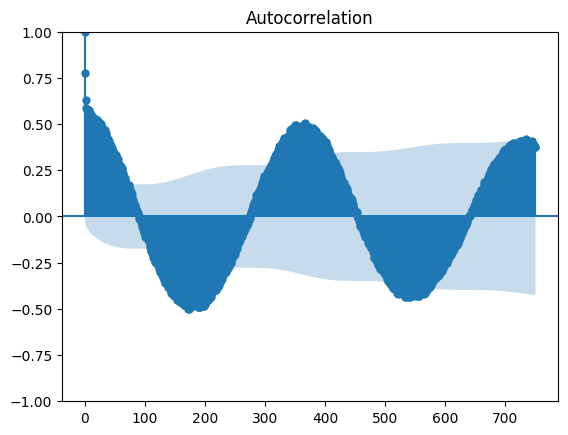

In [82]:
plot_acf(ts, lags = 750);

In [169]:
matrix = transform_to_matrix(ts, 365)

### Задание 3.

Добавьте в модель следующие дополнительные признаки

* Для всех лагов кроме целевого на каждой строчке матрицы расчитайте среднее и стандартное отклонение (не включайте текущий лаг на данном объекте, чтобы избежать лика информации из будущего).
  
Для всех обьектов добавьте в качестве признаков следующие datetime признаки (см пример в основном обзоре)
1. sin/cos проекции дня недели текущего объекта на единичный круг
2. sin/cos проекции месяца текущего объекта на единичный круг
3. sin/cos проекции дня текущего объекта на единичный круг

Подсказка (получить соответствующие значения можно из аттрибутов обьекта datetime)

In [170]:
mean_col, std_col = matrix.iloc[:,0:365].mean(axis = 1), matrix.iloc[:,0:365].std(axis = 1)

In [171]:
matrix.insert(0, 'mean', mean_col)
matrix.insert(1, 'std', std_col)

In [178]:
# def projection(dur, value, sin_cos):
#     dct = {'week_day' : 7, 'month_day' : 31, 'month' : 12}
#     num = dct[dur]
#     sin = np.sin(value * 2 * np.pi/num)
#     cos = np.cos(value * 2 * np.pi/num)
#     if sin_cos == 'sin':
#         return sin
#     if sin_cos == 'cos':
#         return cos

In [173]:
# matrix.index.day.map(lambda x: projection('month_day', x, sin_cos = 'sin')).values

In [174]:
import math

from pandas._libs.tslibs.timestamps import Timestamp


def get_month_sin(timestamp: Timestamp) -> float:
    theta = timestamp.month * (2*math.pi / 12)
    return math.sin(theta)


def get_month_cos(timestamp: Timestamp) -> float:
    theta = timestamp.month * (2*math.pi / 12)
    return math.cos(theta)


def get_day_sin(timestamp: Timestamp) -> float:
    theta = timestamp.day * (2*math.pi / timestamp.days_in_month)
    return math.sin(theta)


def get_day_cos(timestamp: Timestamp) -> float:
    theta = timestamp.day * (2*math.pi / timestamp.days_in_month)
    return math.cos(theta)


def get_dayofweek_sin(timestamp: Timestamp) -> float:
    theta = timestamp.dayofweek * (2*math.pi / 7)
    return math.sin(theta)


def get_dayofweek_cos(timestamp: Timestamp) -> float:
    theta = timestamp.dayofweek * (2*math.pi / 7)
    return math.cos(theta)


def get_hour_sin(timestamp: Timestamp) -> float:
    theta = timestamp.hour * (2*math.pi / 24)
    return math.sin(theta)


def get_hour_cos(timestamp: Timestamp) -> float:
    theta = timestamp.hour * (2*math.pi / 24)
    return math.cos(theta)


def get_minute_sin(timestamp: Timestamp) -> float:
    theta = timestamp.minute * (2*math.pi / 60)
    return math.sin(theta)


def get_minute_cos(timestamp: Timestamp) -> float:
    theta = timestamp.minute * (2*math.pi / 60)
    return math.cos(theta)


datetime_mappers = {
    'month_sin': get_month_sin,
    'month_cos': get_month_cos,
    'day_sin': get_day_sin,
    'day_cos': get_day_cos,
    'dayofweek_sin': get_dayofweek_sin,
    'dayofweek_cos': get_dayofweek_cos,
    'hour_sin': get_hour_sin,
    'hour_cos': get_hour_cos,
    'minute_sin': get_minute_sin,
    'minute_cos': get_minute_cos,
}

In [175]:
for nm, func in datetime_mappers.items():
    matrix[nm] = matrix.index.map(func)

In [176]:
matrix

,mean,std,lag 365,lag 364,lag 363,lag 362,lag 361,lag 360,lag 359,lag 358,...,month_sin,month_cos,day_sin,day_cos,dayofweek_sin,dayofweek_cos,hour_sin,hour_cos,minute_sin,minute_cos
1981-01-01,,,,,,,,,,,,,,,,,,,,,
1982-01-02,11.507123,4.320200,17.9,18.8,14.6,15.8,15.8,15.8,17.4,21.8,...,5.000000e-01,0.866025,3.943559e-01,0.918958,-0.974928,-0.222521,0.0,1.0,0.0,1.0
1982-01-03,11.499178,4.311067,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,...,5.000000e-01,0.866025,5.712682e-01,0.820763,-0.781831,0.623490,0.0,1.0,0.0,1.0
1982-01-04,11.484658,4.295306,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,...,5.000000e-01,0.866025,7.247928e-01,0.688967,0.000000,1.000000,0.0,1.0,0.0,1.0
1982-01-05,11.486301,4.296616,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,...,5.000000e-01,0.866025,8.486443e-01,0.528964,0.781831,0.623490,0.0,1.0,0.0,1.0
1982-01-06,11.478630,4.291390,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,...,5.000000e-01,0.866025,9.377521e-01,0.347305,0.974928,-0.222521,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990-12-27,11.649589,3.855235,13.3,11.7,10.4,14.4,12.7,14.8,13.3,15.6,...,-2.449294e-16,1.000000,-7.247928e-01,0.688967,0.433884,-0.900969,0.0,1.0,0.0,1.0
1990-12-28,11.651507,3.856232,11.7,10.4,14.4,12.7,14.8,13.3,15.6,14.5,...,-2.449294e-16,1.000000,-5.712682e-01,0.820763,-0.433884,-0.900969,0.0,1.0,0.0,1.0
1990-12-29,11.656712,3.857580,10.4,14.4,12.7,14.8,13.3,15.6,14.5,14.3,...,-2.449294e-16,1.000000,-3.943559e-01,0.918958,-0.974928,-0.222521,0.0,1.0,0.0,1.0


### Задание 4.

Разделите на train/test в соотношении примерно 0.7 на 0.3, а также на X и y

Обратите внимание что тест всегда должен быть после трейна, чтобы избежать ликов из будущего, поэтому никакого stratified split

In [118]:
# <your code here>

### Задание 5. 

Обучите модель линейной регрессии из sklearn (LinearRegression, Ridge, Lasso)`

In [119]:
# <your code here>

Lasso()

### Задание 6.

Сделайте in-sample прогноз на test (по сути это просто вызов метода predict на данных из теста)

Нарисуйте рядом графики прогноза

In [120]:
# <your_code_here>

### Задание 7.

Сделайте out-of-sample прогноз на test.

Данный прогноз делается рекурсивным способом по следующему алгоритму:

Пусть есть временной ряд $Y_T$. 

1) Для следующей точки $Y_{T+1}$, в качестве лагов обьекта возьмите предыдущие $num\_lags$ точек.  
2) Добавьте дополнительные признаки к лагам  
3) Сделайте прогноз на полученном обьекте моделью линейной регрессии  
4) Добавьте прогноз к ряду $Y_T$  
5) Повторите пункт 1

И так далее пока не сделаeте прогноз до конца тестовой выборки.

In [144]:
# <your_code_here>


/var/folders/xk/304zh5617yn50x0ys84shn5m0000gn/T/ipykernel_52426/3253606764.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_pred = pd.Series()
